In [1]:
# Standard library imports
import sys
import shutil
from pathlib import Path

# Contributed imports
import geopandas as gpd
import numpy as np

# Our imports
from multiview_mapping_toolkit.cameras.derived_cameras import MetashapeCameraSet
from multiview_mapping_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_mapping_toolkit.utils.visualization import show_segmentation_labels

sys.path.append("../..")
from constants import (
    LABELS_COLUMN,
    LABELS_FILENAME,
    get_labeled_mesh_filename,
    get_mesh_filename,
    get_camera_filename,
    get_DTM_filename,
    get_image_folder,
    get_oblique_images_folder,
    get_images_near_labels_folder,
    get_render_scratch_folder,
    get_render_folder,
)

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set constants
You should be able to define most of the behavior from these constants

In [2]:
SHORT_MODEL_NAME = "delta"

In [3]:
## Parameters to control the outputs
# Repeat the labeling process
RETEXTURE = True
# Points less than this height (meters) above the DTM are considered ground
HEIGHT_ABOVE_GROUND_THRESH = 2
# The image is downsampled to this fraction for accelerated rendering
RENDER_IMAGE_SCALE = 1
# Cameras within this distance of the traing data are used in the rendering process
BUFFER_RADIUS_METERS = 50
# Downsample target
DOWNSAMPLE_TARGET = 1

# Geospatial processing

Preprocess the geospatial data to be as expected.

<Axes: >

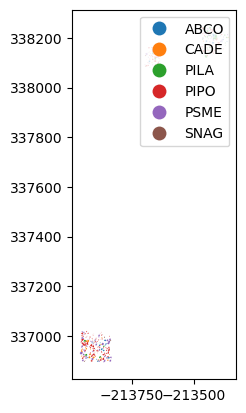

In [4]:
# Load the data
gdf = gpd.read_file(LABELS_FILENAME)

gdf.query(f"fire=='{SHORT_MODEL_NAME}'").plot(
    LABELS_COLUMN, legend=True, vmin=0, vmax=9
)

# Load a set of cameras and downsample them to the region around annotations

Loading GPS data for camera set: 100%|██████████| 33282/33282 [00:00<00:00, 2180385.58it/s]
/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/pyvista/plotting/plotter.py:149: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(
/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


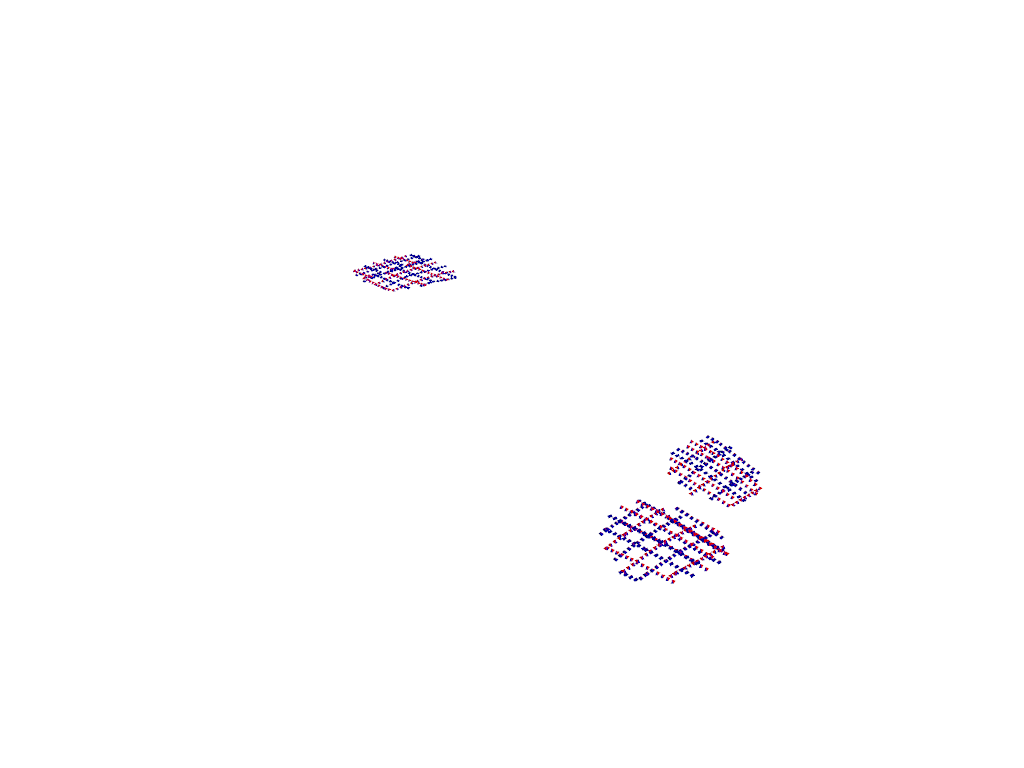

In [5]:
IMAGE_FOLDER = get_image_folder(SHORT_MODEL_NAME)
IMAGE_FOLDER_OBLIQUE = get_oblique_images_folder(SHORT_MODEL_NAME)
CAMERAS_FILENAME = get_camera_filename(SHORT_MODEL_NAME)

# Create camera set
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_ROI(
    ROI=LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METERS
)
training_camera_set = training_camera_set.get_cameras_in_folder(IMAGE_FOLDER_OBLIQUE)
training_camera_set.vis(force_xvfb=True, frustum_scale=0.5)

# Load the mesh and read texture from geopolygon

In [6]:
MESH_FILENAME = get_mesh_filename(SHORT_MODEL_NAME)
LABELED_MESH_FILENAME = get_labeled_mesh_filename(SHORT_MODEL_NAME)
DTM_FILENAME = get_DTM_filename(SHORT_MODEL_NAME)


# Create a labeled version of the mesh from the field data
# if not present or requested
if not Path(LABELED_MESH_FILENAME).is_file() or RETEXTURE:
    # Load the downsampled mesh and apply the texture from the vector file
    mesh = TexturedPhotogrammetryMesh(
        MESH_FILENAME,
        downsample_target=DOWNSAMPLE_TARGET,
        ROI=LABELS_FILENAME,
        ROI_buffer_meters=BUFFER_RADIUS_METERS,
        texture=LABELS_FILENAME,
        texture_column_name=LABELS_COLUMN,
        transform_filename=CAMERAS_FILENAME,
    )
    # Label the ground class
    mesh.label_ground_class(
        DTM_file=DTM_FILENAME,
        height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
        only_label_existing_labels=True,
        ground_class_name="ground",
        ground_ID=np.nan,
        set_mesh_texture=True,
    )

    mesh.save_mesh(LABELED_MESH_FILENAME, save_vert_texture=True)
else:
    mesh = TexturedPhotogrammetryMesh(
        LABELED_MESH_FILENAME, transform_filename=CAMERAS_FILENAME
    )
class_names = mesh.get_label_names()
print(f"IDs to labels: {mesh.IDs_to_labels}")

Loading transform to EPSG:4326


Loading mesh
Reading the mesh
Selecting an ROI from mesh
Standardizing ROI
Dissolving ROI
Setting CRS and buffering ROI
Dissolving buffered ROI
Extracting verts for dataframe
Checking intersection of verts with ROI
Extracting points from pyvista mesh
Extraction surface from subset mesh
Extracting faces from mesh
Loading texture
Could not read texture as a scalar from the pyvista mesh
Could not read texture as a numpy file


Sampling values from raster /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/02_photogrammetry/exports/dtms/delta.tif: 100%|██████████| 806199/806199 [00:34<00:00, 23353.20it/s]


This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices
IDs to labels: {0: 'ABCO', 1: 'CADE', 2: 'PILA', 3: 'PIPO', 4: 'PSME', 5: 'SNAG'}


# Show the mesh

This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


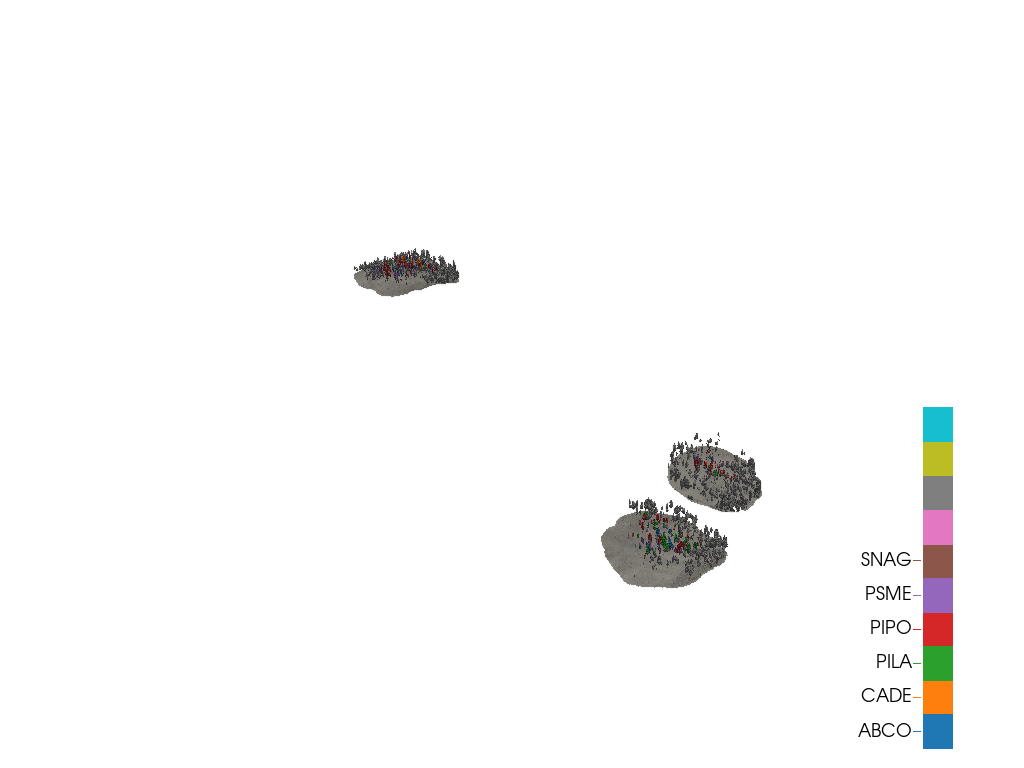

In [7]:
# You can include the camera set, but it's cleaner without it
mesh.vis(camera_set=None, force_xvfb=True)

# Render the labels onto the images

In [8]:
RENDER_FOLDER_SCRATCH = get_render_scratch_folder(SHORT_MODEL_NAME)

mesh.save_renders_pytorch3d(
    camera_set=training_camera_set,
    render_image_scale=RENDER_IMAGE_SCALE,
    save_native_resolution=True,
    output_folder=RENDER_FOLDER_SCRATCH,
)

Saving renders to /home/russelldj/scratch/organized_str_disp_MVMT_experiments/per_site_processing/delta/03_training_data/renders
Saving IDs_to_labels to /home/russelldj/scratch/organized_str_disp_MVMT_experiments/per_site_processing/delta/03_training_data/renders/IDs_to_labels.json


Saving renders: 100%|██████████| 708/708 [2:04:40<00:00, 10.57s/it]  


# Save out the subset of images near the labels

In [9]:
IMAGES_NEAR_LABELS_FOLDER = get_images_near_labels_folder(SHORT_MODEL_NAME)

if not IMAGES_NEAR_LABELS_FOLDER.is_dir():
    print(f"Saving subset of images near labels to {IMAGES_NEAR_LABELS_FOLDER}")
    training_camera_set.save_images(IMAGES_NEAR_LABELS_FOLDER)

Saving subset of images near labels to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/03_training_data/images_near_labels


100%|██████████| 708/708 [00:02<00:00, 265.08it/s]


# Show some of the rendered labels

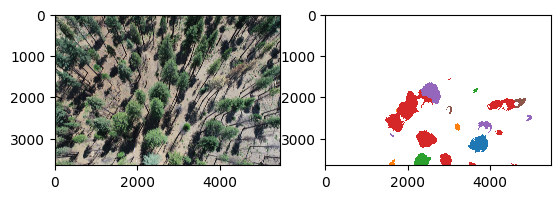

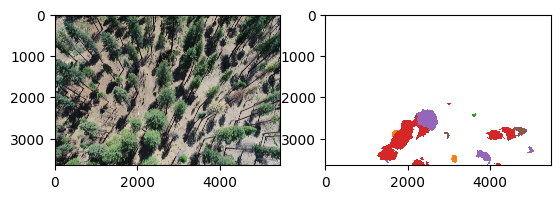

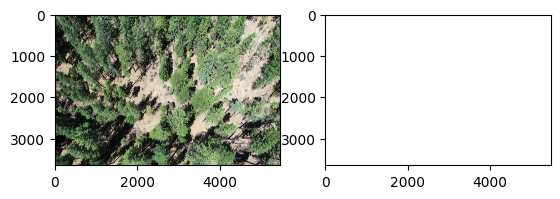

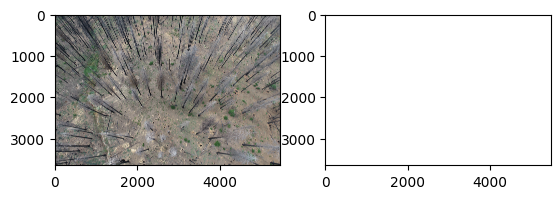

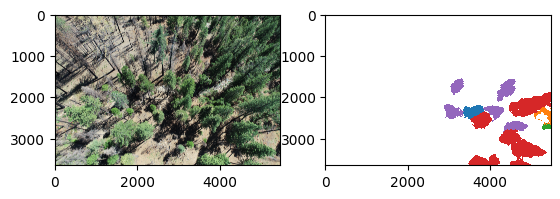

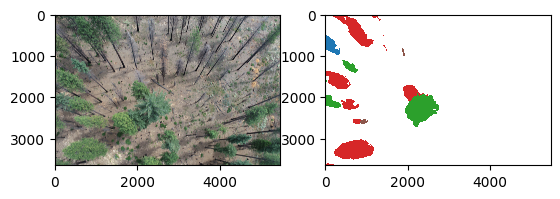

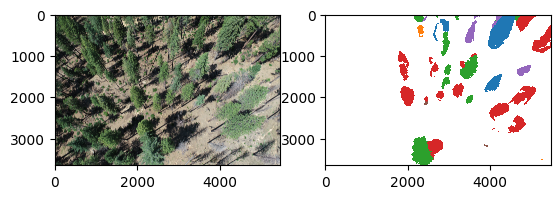

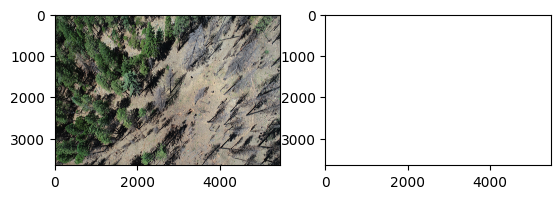

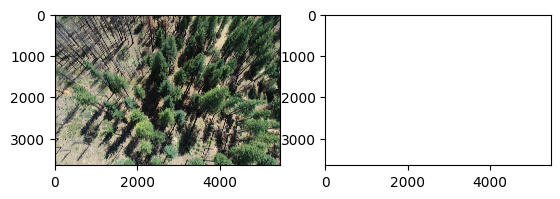

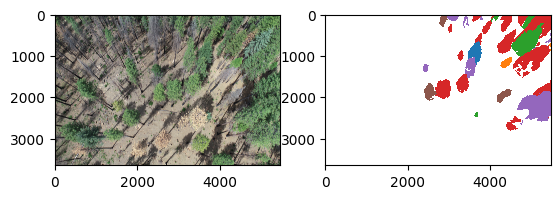

In [10]:
show_segmentation_labels(label_folder=RENDER_FOLDER_SCRATCH, image_folder=IMAGE_FOLDER)

# Copy files from scratch

In [11]:
RENDER_FOLDER = get_render_folder(SHORT_MODEL_NAME)
shutil.copytree(src=RENDER_FOLDER_SCRATCH, dst=RENDER_FOLDER, dirs_exist_ok=True)

PosixPath('/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/delta/03_training_data/renders')